In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import plotly.express as px
import matplotlib.pyplot as plt
import re
import os
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Reading the data
ens_learn = pd.read_csv('/content/drive/MyDrive/Skripsi/datasetIKN.csv')
ens_learn_copy = ens_learn
# Checking first 10 rows of data
ens_learn.head(10)

,Isi_komentar,Keterangan,Label
0,saya sangat setuju pak bahkan lebih setuju ket...,positif,0
1,Saya setuju ibu kota pindah tapi ga sekarang,positif,0
2,Saya dan mayoritas rakyat NKRI setuju pindah I...,positif,0
3,cocok ibu kota pindah ke kalimantan apalagi gu...,cenderung positif,1
4,Jadi kepada lo yang gak setuju ibu kota di pin...,negatif,4
5,Dan Alhamdulillah Gerinda setuju pemindahan ib...,negatif,4
6,Ibu kota tidak darurat untuk pindah yang darur...,positif,0
7,Aku sih setuju ibu kota pindah di Kalimantan,positif,0
8,Proyek IKN hanya menguntungkan Oligarki tanpa ...,cenderung positif,1
9,Kami tolak Pemindahan Ibu Kota Negara IKN Proy...,positif,0


In [4]:
# case folding

def clean_text(text):
  # Check if text is a string before applying re.sub
  if isinstance(text, str):
    return re.sub('[^a-zA-Z]', ' ', text).lower()
  else:
    # Handle non-string values (e.g., NaN) by returning an empty string
    return ''

ens_learn['cleaned_text'] = ens_learn['Isi_komentar'].apply(lambda x: clean_text(x))
ens_learn.head()

,Isi_komentar,Keterangan,Label,cleaned_text
0,saya sangat setuju pak bahkan lebih setuju ket...,positif,0,saya sangat setuju pak bahkan lebih setuju ket...
1,Saya setuju ibu kota pindah tapi ga sekarang,positif,0,saya setuju ibu kota pindah tapi ga sekarang
2,Saya dan mayoritas rakyat NKRI setuju pindah I...,positif,0,saya dan mayoritas rakyat nkri setuju pindah i...
3,cocok ibu kota pindah ke kalimantan apalagi gu...,cenderung positif,1,cocok ibu kota pindah ke kalimantan apalagi gu...
4,Jadi kepada lo yang gak setuju ibu kota di pin...,negatif,4,jadi kepada lo yang gak setuju ibu kota di pin...


In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords

all_stopwords = stopwords.words('indonesian')
all_stopwords.remove('boleh')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# Removing the URl

def rem_url(cleaned_text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',cleaned_text)

# Removing the stepwords 'indonesian'

def rem_stopwords(cleaned_text):
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in (stopwords.words('indonesian'))])
    return cleaned_text

# Removing the html

def rem_html(cleaned_text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',cleaned_text)

def remove_at_mentions(cleaned_text):
    return re.sub(r'@\w+', '', cleaned_text)


# Removing emojis by codes

def rem_emoji(cleaned_text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', cleaned_text)

# Fixing the cleaned_text

def fixing(cleaned_text):
    cleaned_text = re.sub(r"bangke", "tolol", cleaned_text)
    return cleaned_text

# Seperate alphabets

def sep_alphabets(cleaned_text):
    words = cleaned_text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)


def review_to_words(review):
    letters_only = re.sub("[^a-zA-Z]", " ",review)
    words = letters_only.lower().split()
    stops = set(stopwords.words("indonesian"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

ens_learn['filtered_text'] = ens_learn['cleaned_text']

ens_learn['filtered_text'] = ens_learn['filtered_text'].astype(str).apply(remove_at_mentions)
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : rem_url(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : rem_stopwords(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : rem_html(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : rem_emoji(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : sep_alphabets(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : review_to_words(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].astype(str).replace("bangke", "tolol", regex=True)

# result

ens_learn['filtered_text']

,filtered_text
0,setuju setuju mengalokasikan angggaran peminda...
1,setuju kota pindah ga
2,mayoritas rakyat nkri setuju pindah kota negar...
3,cocok kota pindah kalimantan gubernurnya ga ke...
4,lo gak setuju kota pindah lo maunya sih lo tau...
...,...
5061,mulyono bilang ikn pusing ga lu artikan kalima...
5062,kl undang undang negeri diprint setebal ya atu...
5063,maksud kota nusantara karna pecah indonesia in...
5064,kah


In [7]:
filtered_text = stopwords.words('indonesian')
ens_learn['filtered_text'] = ens_learn['filtered_text']
ens_learn.head()

,Isi_komentar,Keterangan,Label,cleaned_text,filtered_text
0,saya sangat setuju pak bahkan lebih setuju ket...,positif,0,saya sangat setuju pak bahkan lebih setuju ket...,setuju setuju mengalokasikan angggaran peminda...
1,Saya setuju ibu kota pindah tapi ga sekarang,positif,0,saya setuju ibu kota pindah tapi ga sekarang,setuju kota pindah ga
2,Saya dan mayoritas rakyat NKRI setuju pindah I...,positif,0,saya dan mayoritas rakyat nkri setuju pindah i...,mayoritas rakyat nkri setuju pindah kota negar...
3,cocok ibu kota pindah ke kalimantan apalagi gu...,cenderung positif,1,cocok ibu kota pindah ke kalimantan apalagi gu...,cocok kota pindah kalimantan gubernurnya ga ke...
4,Jadi kepada lo yang gak setuju ibu kota di pin...,negatif,4,jadi kepada lo yang gak setuju ibu kota di pin...,lo gak setuju kota pindah lo maunya sih lo tau...


In [8]:
# tokenizing

def tokenize_text(text):
  tokenized_text = text.split()
  return tokenized_text
ens_learn['tokens'] = ens_learn['filtered_text'].apply(lambda x: tokenize_text(x))
ens_learn.head()

,Isi_komentar,Keterangan,Label,cleaned_text,filtered_text,tokens
0,saya sangat setuju pak bahkan lebih setuju ket...,positif,0,saya sangat setuju pak bahkan lebih setuju ket...,setuju setuju mengalokasikan angggaran peminda...,"[setuju, setuju, mengalokasikan, angggaran, pe..."
1,Saya setuju ibu kota pindah tapi ga sekarang,positif,0,saya setuju ibu kota pindah tapi ga sekarang,setuju kota pindah ga,"[setuju, kota, pindah, ga]"
2,Saya dan mayoritas rakyat NKRI setuju pindah I...,positif,0,saya dan mayoritas rakyat nkri setuju pindah i...,mayoritas rakyat nkri setuju pindah kota negar...,"[mayoritas, rakyat, nkri, setuju, pindah, kota..."
3,cocok ibu kota pindah ke kalimantan apalagi gu...,cenderung positif,1,cocok ibu kota pindah ke kalimantan apalagi gu...,cocok kota pindah kalimantan gubernurnya ga ke...,"[cocok, kota, pindah, kalimantan, gubernurnya,..."
4,Jadi kepada lo yang gak setuju ibu kota di pin...,negatif,4,jadi kepada lo yang gak setuju ibu kota di pin...,lo gak setuju kota pindah lo maunya sih lo tau...,"[lo, gak, setuju, kota, pindah, lo, maunya, si..."


In [9]:
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi Stemmer Bahasa Indonesia
stemmer = StemmerFactory().create_stemmer()

# Fungsi Lemmatisasi (Stemming) untuk Bahasa Indonesia
def stem_text(token_list):
    return " ".join([stemmer.stem(token) for token in token_list])

# Menerapkan Stemming pada DataFrame
ens_learn['stemmed_review'] = ens_learn['tokens'].apply(lambda x: stem_text(x))
ens_learn.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 20.2 MB/s eta 0:00:00


,Isi_komentar,Keterangan,Label,cleaned_text,filtered_text,tokens,stemmed_review
0,saya sangat setuju pak bahkan lebih setuju ket...,positif,0,saya sangat setuju pak bahkan lebih setuju ket...,setuju setuju mengalokasikan angggaran peminda...,"[setuju, setuju, mengalokasikan, angggaran, pe...",tuju tuju alokasi angggaran pindah kota anggar...
1,Saya setuju ibu kota pindah tapi ga sekarang,positif,0,saya setuju ibu kota pindah tapi ga sekarang,setuju kota pindah ga,"[setuju, kota, pindah, ga]",tuju kota pindah ga
2,Saya dan mayoritas rakyat NKRI setuju pindah I...,positif,0,saya dan mayoritas rakyat nkri setuju pindah i...,mayoritas rakyat nkri setuju pindah kota negar...,"[mayoritas, rakyat, nkri, setuju, pindah, kota...",mayoritas rakyat nkri tuju pindah kota negara ...
3,cocok ibu kota pindah ke kalimantan apalagi gu...,cenderung positif,1,cocok ibu kota pindah ke kalimantan apalagi gu...,cocok kota pindah kalimantan gubernurnya ga ke...,"[cocok, kota, pindah, kalimantan, gubernurnya,...",cocok kota pindah kalimantan gubernur ga kerja...
4,Jadi kepada lo yang gak setuju ibu kota di pin...,negatif,4,jadi kepada lo yang gak setuju ibu kota di pin...,lo gak setuju kota pindah lo maunya sih lo tau...,"[lo, gak, setuju, kota, pindah, lo, maunya, si...",lo gak tuju kota pindah lo mau sih lo tau jaka...


In [10]:
from IPython.display import display
display(ens_learn)

,Isi_komentar,Keterangan,Label,cleaned_text,filtered_text,tokens,stemmed_review
0,saya sangat setuju pak bahkan lebih setuju ket...,positif,0,saya sangat setuju pak bahkan lebih setuju ket...,setuju setuju mengalokasikan angggaran peminda...,"[setuju, setuju, mengalokasikan, angggaran, pe...",tuju tuju alokasi angggaran pindah kota anggar...
1,Saya setuju ibu kota pindah tapi ga sekarang,positif,0,saya setuju ibu kota pindah tapi ga sekarang,setuju kota pindah ga,"[setuju, kota, pindah, ga]",tuju kota pindah ga
2,Saya dan mayoritas rakyat NKRI setuju pindah I...,positif,0,saya dan mayoritas rakyat nkri setuju pindah i...,mayoritas rakyat nkri setuju pindah kota negar...,"[mayoritas, rakyat, nkri, setuju, pindah, kota...",mayoritas rakyat nkri tuju pindah kota negara ...
3,cocok ibu kota pindah ke kalimantan apalagi gu...,cenderung positif,1,cocok ibu kota pindah ke kalimantan apalagi gu...,cocok kota pindah kalimantan gubernurnya ga ke...,"[cocok, kota, pindah, kalimantan, gubernurnya,...",cocok kota pindah kalimantan gubernur ga kerja...
4,Jadi kepada lo yang gak setuju ibu kota di pin...,negatif,4,jadi kepada lo yang gak setuju ibu kota di pin...,lo gak setuju kota pindah lo maunya sih lo tau...,"[lo, gak, setuju, kota, pindah, lo, maunya, si...",lo gak tuju kota pindah lo mau sih lo tau jaka...
...,...,...,...,...,...,...,...
5061,"Mulyono bilang IKN sudah tapi belum,pusing ga ...",negatif,4,mulyono bilang ikn sudah tapi belum pusing ga ...,mulyono bilang ikn pusing ga lu artikan kalima...,"[mulyono, bilang, ikn, pusing, ga, lu, artikan...",mulyono bilang ikn pusing ga lu arti kalimat n...
5062,"Ini kl undang undang di negeri ini diprint, ki...",negatif,4,ini kl undang undang di negeri ini diprint ki...,kl undang undang negeri diprint setebal ya atu...,"[kl, undang, undang, negeri, diprint, setebal,...",kl undang undang negeri diprint setebal ya atu...
5063,Maksud Ibu Kota Nusantara\nKarna Mereka akan p...,netral,2,maksud ibu kota nusantara karna mereka akan pe...,maksud kota nusantara karna pecah indonesia in...,"[maksud, kota, nusantara, karna, pecah, indone...",maksud kota nusantara karna pecah indonesia in...
5064,Sudah saatnya kah,netral,2,sudah saatnya kah,kah,[kah],kah


In [11]:
display(ens_learn[['Label','Keterangan', 'stemmed_review']])

,Label,Keterangan,stemmed_review
0,0,positif,tuju tuju alokasi angggaran pindah kota anggar...
1,0,positif,tuju kota pindah ga
2,0,positif,mayoritas rakyat nkri tuju pindah kota negara ...
3,1,cenderung positif,cocok kota pindah kalimantan gubernur ga kerja...
4,4,negatif,lo gak tuju kota pindah lo mau sih lo tau jaka...
...,...,...,...
5061,4,negatif,mulyono bilang ikn pusing ga lu arti kalimat n...
5062,4,negatif,kl undang undang negeri diprint setebal ya atu...
5063,2,netral,maksud kota nusantara karna pecah indonesia in...
5064,2,netral,kah


In [12]:
ens_learn.to_csv("preprocessingIKN.csv", index = False) # Replace 'my_ens_learn' with 'ens_learn'

In [13]:
# Baca file CSV menjadi DataFrame
ens_learn = pd.read_csv('preprocessingIKN.csv')

# Hapus baris dengan nilai kosong
ens_learn_cleaned = ens_learn.dropna()

# Tampilkan DataFrame setelah penghapusan
print("\nDataFrame Setelah Penghapusan:")
display(ens_learn)

# Simpan DataFrame setelah penghapusan ke file CSV baru (opsional)
ens_learn_cleaned.to_csv('preprocessingKendaraanListrik.csv', index=False)


DataFrame Setelah Penghapusan:


,Isi_komentar,Keterangan,Label,cleaned_text,filtered_text,tokens,stemmed_review
0,saya sangat setuju pak bahkan lebih setuju ket...,positif,0,saya sangat setuju pak bahkan lebih setuju ket...,setuju setuju mengalokasikan angggaran peminda...,"['setuju', 'setuju', 'mengalokasikan', 'anggga...",tuju tuju alokasi angggaran pindah kota anggar...
1,Saya setuju ibu kota pindah tapi ga sekarang,positif,0,saya setuju ibu kota pindah tapi ga sekarang,setuju kota pindah ga,"['setuju', 'kota', 'pindah', 'ga']",tuju kota pindah ga
2,Saya dan mayoritas rakyat NKRI setuju pindah I...,positif,0,saya dan mayoritas rakyat nkri setuju pindah i...,mayoritas rakyat nkri setuju pindah kota negar...,"['mayoritas', 'rakyat', 'nkri', 'setuju', 'pin...",mayoritas rakyat nkri tuju pindah kota negara ...
3,cocok ibu kota pindah ke kalimantan apalagi gu...,cenderung positif,1,cocok ibu kota pindah ke kalimantan apalagi gu...,cocok kota pindah kalimantan gubernurnya ga ke...,"['cocok', 'kota', 'pindah', 'kalimantan', 'gub...",cocok kota pindah kalimantan gubernur ga kerja...
4,Jadi kepada lo yang gak setuju ibu kota di pin...,negatif,4,jadi kepada lo yang gak setuju ibu kota di pin...,lo gak setuju kota pindah lo maunya sih lo tau...,"['lo', 'gak', 'setuju', 'kota', 'pindah', 'lo'...",lo gak tuju kota pindah lo mau sih lo tau jaka...
...,...,...,...,...,...,...,...
5061,"Mulyono bilang IKN sudah tapi belum,pusing ga ...",negatif,4,mulyono bilang ikn sudah tapi belum pusing ga ...,mulyono bilang ikn pusing ga lu artikan kalima...,"['mulyono', 'bilang', 'ikn', 'pusing', 'ga', '...",mulyono bilang ikn pusing ga lu arti kalimat n...
5062,"Ini kl undang undang di negeri ini diprint, ki...",negatif,4,ini kl undang undang di negeri ini diprint ki...,kl undang undang negeri diprint setebal ya atu...,"['kl', 'undang', 'undang', 'negeri', 'diprint'...",kl undang undang negeri diprint setebal ya atu...
5063,Maksud Ibu Kota Nusantara\nKarna Mereka akan p...,netral,2,maksud ibu kota nusantara karna mereka akan pe...,maksud kota nusantara karna pecah indonesia in...,"['maksud', 'kota', 'nusantara', 'karna', 'peca...",maksud kota nusantara karna pecah indonesia in...
5064,Sudah saatnya kah,netral,2,sudah saatnya kah,kah,['kah'],kah


In [14]:
#Checking number of null values

ens_learn.isna().sum()

,0
Isi_komentar,0
Keterangan,0
Label,0
cleaned_text,0
filtered_text,65
tokens,0
stemmed_review,65


In [15]:
allowed_labels = [
    "cenderung positif", "positif", "netral",
    "negatif", "cenderung negatif"
]

ens_learn = ens_learn[ens_learn['Keterangan'].isin(allowed_labels)]

In [16]:
# Check the number of sentiments based on the rating
# shape of the dataset, and breakdown of the classes

print(f"Input data has {len(ens_learn)} rows and {len(ens_learn.columns)} columns")
print(f"rating 0 = {len(ens_learn[ens_learn['Label']==0])} rows")
print(f"rating 1 = {len(ens_learn[ens_learn['Label']==1])} rows")
print(f"rating 2 = {len(ens_learn[ens_learn['Label']==2])} rows")
print(f"rating 3 = {len(ens_learn[ens_learn['Label']==3])} rows")
print(f"rating 4 = {len(ens_learn[ens_learn['Label']==4])} rows")

Input data has 5065 rows and 7 columns
rating 0 = 1208 rows
rating 1 = 447 rows
rating 2 = 1611 rows
rating 3 = 208 rows
rating 4 = 1591 rows


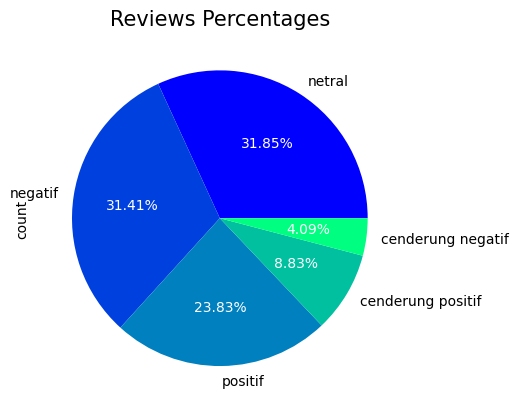

In [17]:
plt.title("Reviews Percentages", fontsize=15)
ax = ens_learn['Keterangan'].value_counts().plot(
    kind='pie', autopct='%1.2f%%', cmap="winter",
)

# Set label angka persentase menjadi warna putih
for text in ax.texts:
    # Jika teks adalah persentase (di dalam diagram), ubah warnanya menjadi putih
    if '%' in text.get_text():
        text.set_color('white')
    # Jika teks adalah label (di luar diagram), ubah warnanya menjadi hitam
    else:
        text.set_color('black')

plt.show()

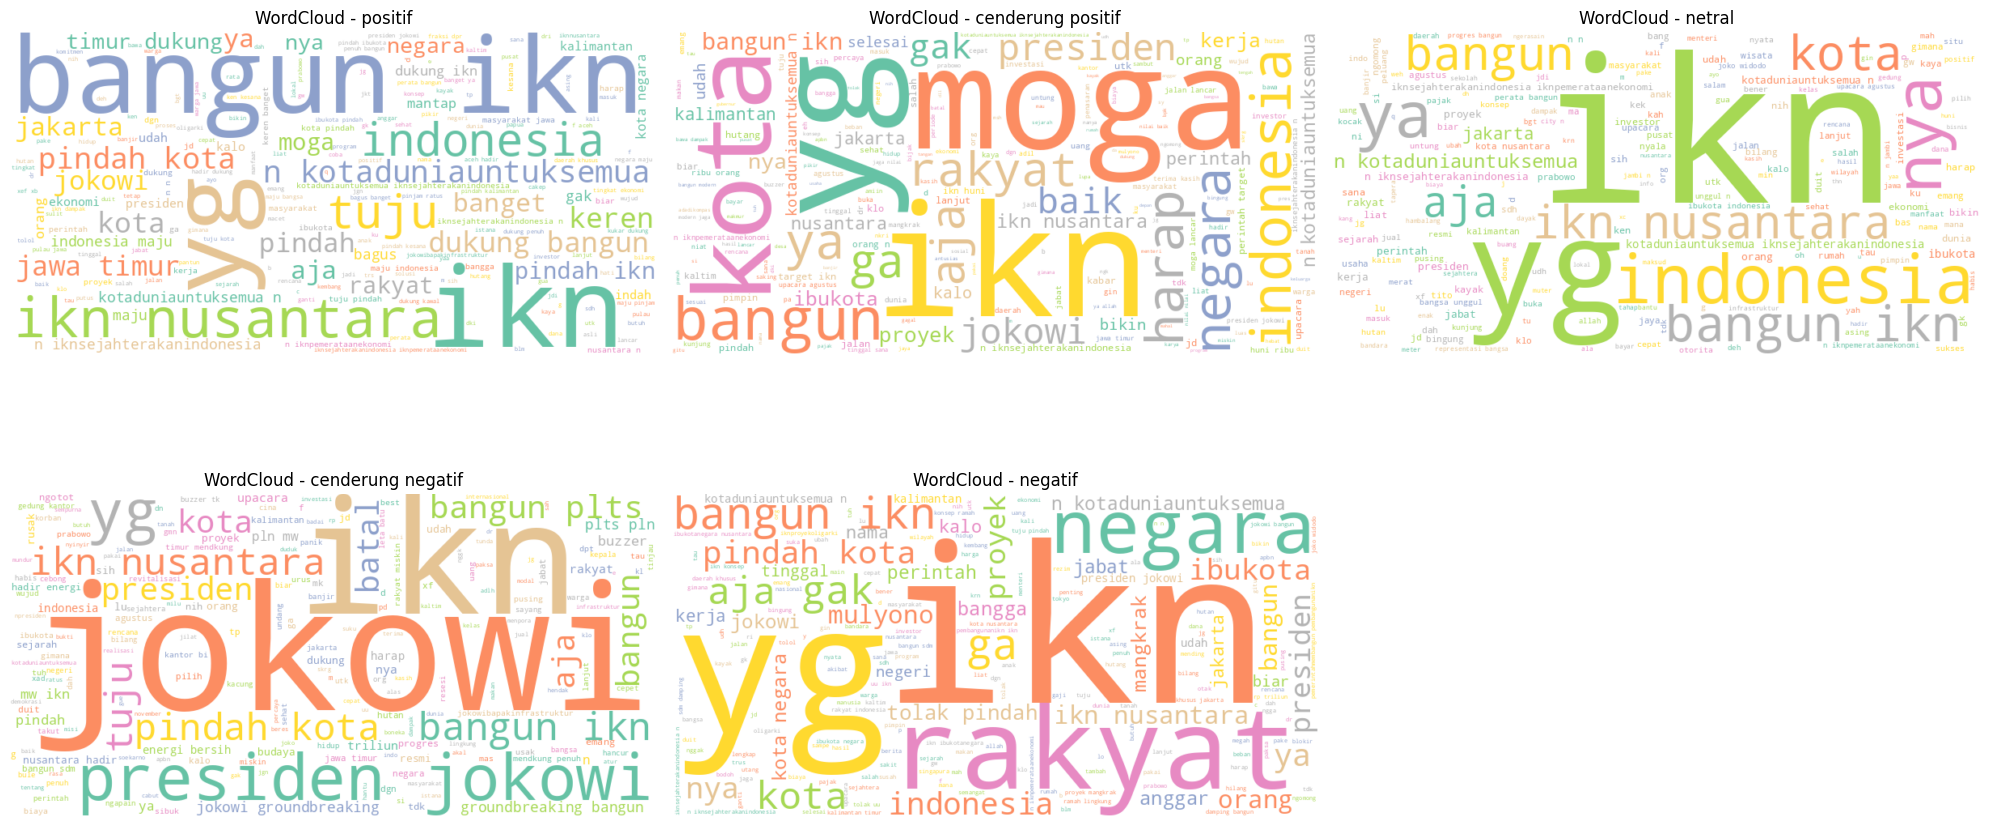

In [18]:
import pandas as pd
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Copy dataframe untuk cleaning tanpa merusak data asli
data = ens_learn.copy()

# --- CLEANING TAMBAHAN (WAJIB AGAR https HILANG) ---
# Hapus NaN dan jadikan string
data['stemmed_review'] = data['stemmed_review'].fillna('').astype(str)

# Hapus URL (http, https, www)
data['stemmed_review'] = data['stemmed_review'].map(
    lambda x: re.sub(r'http\S+|www\.\S+', '', x)
)

# Hapus tanda baca
data['stemmed_review'] = data['stemmed_review'].map(
    lambda x: re.sub(r'[,\.!?]', '', x)
)

# Lowercase
data['stemmed_review'] = data['stemmed_review'].str.lower()

# Tambahan stopwords untuk menghilangkan kata tidak penting
custom_stopwords = STOPWORDS.union({
    'https', 'http', 'www', 'com', 'xe', 'xa', 'co', 't', 'x', 'xa'
})

# Label mapping
label_names = {
    0: 'positif',
    1: 'cenderung positif',
    2: 'netral',
    3: 'cenderung negatif',
    4: 'negatif'
}

actual_labels = sorted(data['Label'].unique())

# Plot
plt.figure(figsize=(20, 10))

for i, label_value in enumerate(actual_labels):
    texts = data[data['Label'] == label_value]['stemmed_review']
    combined_text = ' '.join(texts)

    if not combined_text.strip():
        print(f"Skipping WordCloud for Label {label_value} as no text found.")
        continue

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Set2',
        stopwords=custom_stopwords
    ).generate(combined_text)

    plt.subplot(2, 3, i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud - {label_names.get(label_value)}')

plt.tight_layout()
plt.show()

In [19]:
!pip install transformers

In [25]:
from transformers import BertTokenizer

print("Loading IndoBERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased', do_lower_case=True)

Loading IndoBERT Tokenizer


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [26]:
# Dengan asumsi 'ens_learn' berisi kolom bernama 'filtered_text' dengan kalimat Anda
sentences = ens_learn['filtered_text'].tolist()

print("Original: ", sentences[21])

print("Tokenized: ", tokenizer.tokenize (sentences[48]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[48])))

Original:  klo sy sih setuju ttg pemindahan kota kondisi demografi jawa yg sdh padat hrs dibangun berdaulat
Tokenized:  ['dukung', 'presiden', 'kota', 'pemerintahan', 'cepat', 'pindah', 'kalimantan', 'ade', '##m', 'aman']
Token IDS:  [17543, 2134, 1850, 2716, 3218, 4951, 4092, 12822, 931, 4022]


In [27]:
print("Original: ", sentences[67])

print("Tokenized: ", tokenizer.tokenize (sentences[67]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[67])))

Original:  rakyat indonesia setuju dgn pemindahan kota negara
Tokenized:  ['rakyat', 'indonesia', 'setuju', 'dgn', 'pemindahan', 'kota', 'negara']
Token IDS:  [2425, 1718, 5692, 11794, 13699, 1850, 1806]


Fungsi tokenizer.encode menggabungkan beberapa langkah:

1. Membagi kalimat menjadi token.
2. Tambahkan token khusus [CLS] dan [SEP].
3. Petakan token ke ID mereka.

In [28]:
input_ids = []

for sent in sentences:
    # Check if sent is a string before tokenizing
    if isinstance(sent, str):
        # Tokenisasi kalimat tanpa menambahkan token [CLS] dan [SEP]
        tokens = tokenizer.tokenize(sent)

        # Menambahkan token [CLS] di awal dan [SEP] di akhir
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        # Mengonversi token menjadi ID menggunakan tokenizer
        encoded_sent = tokenizer.convert_tokens_to_ids(tokens)

        input_ids.append(encoded_sent)
    else:
        # Handle non-string values (e.g., NaN) by appending an empty list or a special token ID
        input_ids.append([tokenizer.cls_token_id, tokenizer.sep_token_id])  # Example: append [CLS, SEP]

# Menampilkan hasil untuk salah satu kalimat
print("Original: ", sentences[32])
print("Tokenized: ", tokenizer.tokenize(sentences[32]))
print("Token IDs: ", input_ids[32])

Original:  tolak pengesahan uu ikn ketidakuntungan kepentingan rakyat membutuhkan kesejahteraan pasca pandemi pindah ikn
Tokenized:  ['tolak', 'pengesahan', 'uu', 'ik', '##n', 'ketidak', '##untungan', 'kepentingan', 'rakyat', 'membutuhkan', 'kesejahteraan', 'pasca', 'pand', '##emi', 'pindah', 'ik', '##n']
Token IDs:  [3, 12198, 14753, 4786, 2337, 935, 4909, 4635, 3765, 2425, 4712, 5929, 7150, 3021, 4010, 4951, 2337, 935, 4]


In [29]:
# Periksa kalimat sentence (token)

print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  98


In [30]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN =65

print("Padding/trucating all sentence to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/trucating all sentence to 65 values
Padding token: "[PAD]", ID: 0
Done


In [31]:
input_ids[32]

array([    3, 12198, 14753,  4786,  2337,   935,  4909,  4635,  3765,
        2425,  4712,  5929,  7150,  3021,  4010,  4951,  2337,   935,
           4,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [32]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent] # - Jika ID token adalah 0, maka itu adalah padding, set mask ke 0.
                                                      # - Jika ID token > 0, maka itu adalah token asli, set mask ke 1.

  attention_mask.append(att_mask)

In [33]:
# Misalkan batas adalah 10
batas = 10

for i in range(0, len(attention_mask[50]), batas):
    print(attention_mask[50][i:i+batas])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]


Splitting

Membagi data untuk menggunakan 80% untuk pelatihan dan 20% untuk testing.

In [34]:
from sklearn.model_selection import train_test_split

# The 'Label' column already has 0-indexed labels (0 to 4).
# Subtracting 1 was creating invalid labels (e.g., -1).
# Removed '- 1' to keep labels correctly in the range [0, 4].
labels = ens_learn['Label'].values

# Gunakan 80% untuk training dan 20% untuk testing.
train_input, test_input, train_labels, test_labels = train_test_split(
    input_ids,
    labels,
    random_state=2020,  # Mengatur seed agar pembagian dataset dapat direproduksi
    test_size=0.3,      # Ubah test_size menjadi 0.2
    stratify=labels     # Pastikan distribusi label sama di train dan test
)

# Lakukan hal yang sama untuk attention masks.
train_mask, test_mask, _, _ = train_test_split(
    attention_mask,
    labels,
    random_state=2020,
    test_size=0.3,      # Ubah test_size menjadi 0.2
    stratify=labels     # Pastikan distribusi label sama di train dan test
)

In [35]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (3545, 65)
Label:  (3545,)
Mask:  (3545, 65)

== Test ==
Input:  (1520, 65)
Label:  (1520,)
Mask:  (1520, 65)


Creating data loaders

Mengonversi ke Tipe Data PyTorch

In [36]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [37]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [38]:
# Membuat DataLoader dalam PyTorch

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 64

# Create the DataLoader for our training set.
train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our testing set.
test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Modeling
Set-up BERT pretrained model

Menggunakan Transformers library untuk menginisialisasi model BERT (Bidirectional Encoder Representations from Transformers) untuk tugas klasifikasi urutan (sequence classification) dalam bahasa Indonesia.

In [39]:
from transformers import BertForSequenceClassification, BertConfig
# Import AdamW from torch.optim instead of transformers
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained(
    "indolem/indobert-base-uncased",
    num_labels = 5,
    output_attentions = False,
    output_hidden_states = False
)

# Fix: Move the model to the CPU as a workaround for persistent CUDA errors.
model.cuda()

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Mencetak nama-nama dan dimensi dari bobot untuk:

Layer embedding.
Salah satu dari dua belas transformer.
Layer keluaran.

In [40]:
from transformers import EarlyStoppingCallback

callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]

In [41]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

total_params = sum(p.numel() for p in model.parameters())
print("==== Total Parameters ====")
print(f'Total Parameters: {total_params}')

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (31923, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.e

Setting-up optimizer & schedular

Dengan menggunakan optimizer ini, kita dapat mengoptimalkan parameter-model menggunakan metode backpropagation selama proses pelatihan (training).

In [42]:
# Import the AdamW optimizer
from torch.optim import AdamW
import torch
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
# Now we can use AdamW because it's been imported
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

Dalam melakukan komputasi data, pada umumnya menggunakan gradient descent untuk melakukan proses penjumlahan dan turunan dengan tujuan menemukan titik yang meminimumkan suatu fungsi yang dapat diturunkan. Pada penelitian ini menggunakan algoritma AdamW Optimizer. Seperti Stochastic Gradient Descent, namun algoritma Adam W memiliki keunggulan Root Mean Square Propagation yang tidak dimiliki di Stochastic Gradient Descent.

In [43]:
from transformers import get_linear_schedule_with_warmup

epochs = 16

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

Training BERT

In [44]:
import numpy as np

# Menghitung akurasi prediksi model terhadap label pada suatu tugas klasifikasi.
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [45]:
import time
import datetime

# Mengelola waktu yang diukur dalam detik dan mengembalikan waktu yang diformat dengan representasi jam:menit:detik
def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [46]:
import random

# --------------
# PERSIAPAN AWAL
# --------------

# Setting Seed:
# mengatur seed agar hasil eksperimen dapat diproduksi
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Inisialisasi Variabel:
# menyimpan nilai loss selama pelatihan.
loss_values = []


# --------------
# PELATIHAN MODEL
# --------------

# Loop Epoch:
# dilakukan loop sebanyak epochs (jumlah epoch yang ditentukan).
for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time() # measure how long the training epoch takes.

  # Inisialisasi Total Loss:
  # deklasrasi nilai loss = 0 (direset ke 0 di awal setiap epoch).
  total_loss = 0

  # Set Model ke Mode Training:
  # mengaktifkan mode training pada model.
  model.train()

  # Loop Batches:
  # for each batch of training data (dilakukan loop untuk setiap batch di dalam train_dataloader).
  for step, batch in enumerate(train_dataloader):

    # Progress update/progress report every 1 batches:
    # diberikan informasi mengenai progress setiap batch.
    if step % 1 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    # Muat Data ke GPU/CPU:
    # token ids/data masukan, attention masks, dan label dari batch dimuat ke perangkat GPU.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad() # PyTorch
                      # dlm setiap batch, set gradien mjd set zero

    # Forward Pass:
    # model dimasukkan token ids, attention mask, dan label. Output berupa nilai loss.
    outputs = model(b_input_ids,
                    token_type_ids=None,  # diperlukan jika ingin melakukan klasifikasi menggunakan 2 sentences yg dianggap 1 data.
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0] # ambil nilai loss, utk mengambil nilai sebenarnya: menggunakan loss.item kemuddian lakukan backward.

    # Backward Pass:
    # gradien dihitung dan dilakukan backward pass.
    total_loss += loss.item()

    loss.backward()

    # PyTorch
    # Menerapkan normalisasi gradien untuk mencegah eksplosi gradien.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Optimasi dan Scheduler:
    # optimizer melakukan langkah optimisasi (mengupdate parameter model) dan scheduler dipindahkan.
    optimizer.step()

    scheduler.step()

  # Hitung Rata-rata Loss (total loss/jmh batch):
  # rata-rata loss dihitung untuk satu epoch.
  avg_train_loss = total_loss / len(train_dataloader)

  # Simpan Loss:
  # rata-rata loss disimpan di dalam loss_values.
  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))


# ===================================
#             evaluation
# ===================================

# print("Running Evaluation...")

t0 = time.time()

# Set Model ke Mode Evaluasi:
# model.eval() mengubah model ke mode evaluasi.
model.eval()

train_loss, train_accuracy = 0, 0
nb_train_steps, nb_train_examples = 0, 0

# Loop Batches pada Data Uji:
# dilakukan loop untuk setiap batch di dalam train_dataloader.
for batch in train_dataloader:

  # Data disimpan dalam GPU
  # data uji dimuat ke perangkat GPU.
  batch = tuple(t.to(device) for t in batch)

  # Pisahkan batch lagi
  b_input_ids, b_input_mask, b_labels = batch

  # Forward Pass pada Data Uji:
  # dengan torch.no_grad(), model melakukan prediksi pada data uji.
  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  # Mengambil nilai output
  # Labelnya dikembalikan
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()    # Disimpan di CPU, karena akan ada proses matematis sederhana
  label_ids = b_labels.to('cpu').numpy()

  # Hitung Akurasi pada Data Uji (jmh data yg sesuai/seluruh data):
  # akurasi dihitung dengan fungsi flat_accuracy().
  tmp_train_accuracy = flat_accuracy(logits, label_ids)

  train_accuracy += tmp_train_accuracy

  nb_train_steps += 1

# Tampilkan Hasil Pengujian:
# tampilkan akurasi dan waktu pengujian.
print("   Accuracy: {0:.2f}".format(train_accuracy/nb_train_steps))
print("   Testing took: {:}".format(format_time(time.time() - t0)))


print("Training complete!")

======= Epoch 1 / 16 =======
Training...
Batch     1 of    56.     Elapsed: 0:00:02
Batch     2 of    56.     Elapsed: 0:00:02
Batch     3 of    56.     Elapsed: 0:00:02
Batch     4 of    56.     Elapsed: 0:00:03
Batch     5 of    56.     Elapsed: 0:00:03
Batch     6 of    56.     Elapsed: 0:00:04
Batch     7 of    56.     Elapsed: 0:00:05
Batch     8 of    56.     Elapsed: 0:00:05
Batch     9 of    56.     Elapsed: 0:00:06
Batch    10 of    56.     Elapsed: 0:00:06
Batch    11 of    56.     Elapsed: 0:00:07
Batch    12 of    56.     Elapsed: 0:00:07
Batch    13 of    56.     Elapsed: 0:00:08
Batch    14 of    56.     Elapsed: 0:00:09
Batch    15 of    56.     Elapsed: 0:00:09
Batch    16 of    56.     Elapsed: 0:00:10
Batch    17 of    56.     Elapsed: 0:00:10
Batch    18 of    56.     Elapsed: 0:00:11
Batch    19 of    56.     Elapsed: 0:00:12
Batch    20 of    56.     Elapsed: 0:00:12
Batch    21 of    56.     Elapsed: 0:00:13
Batch    22 of    56.     Elapsed: 0:00:13
Batch    23 o

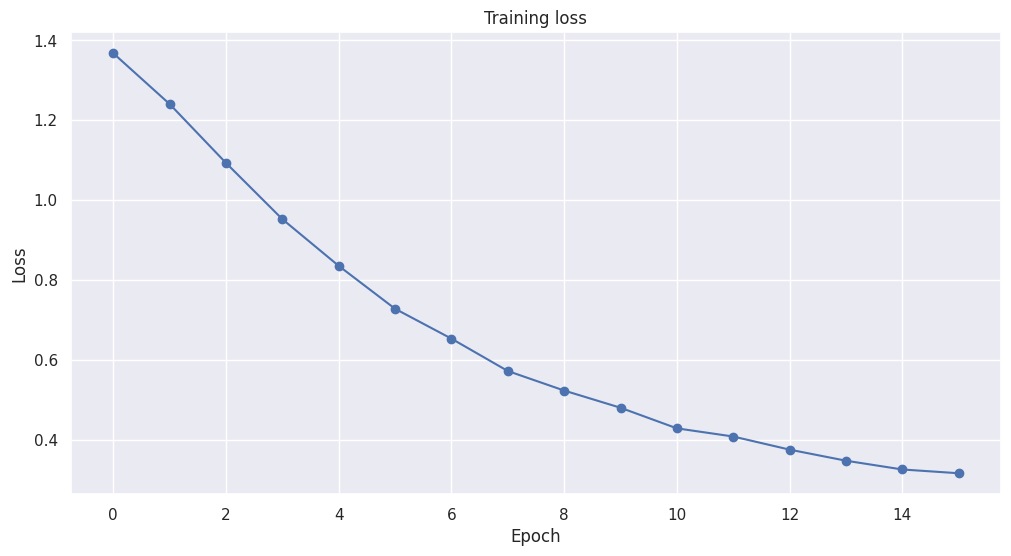

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

**Predict**

In [48]:
# Pastikan import yang diperlukan
import numpy as np

# Simpan hasil prediksi dari model
prediction = []  # Menyimpan logits dari semua batch
true_labels = []  # Menyimpan label sebenarnya

# Loop untuk batch dalam train_dataloader (atau test_dataloader jika evaluasi)
for batch in train_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits.detach().cpu().numpy()
    labels = b_labels.to('cpu').numpy()

    prediction.append(logits)
    true_labels.append(labels)

# Flatten predictions dan true labels
flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = np.array(flat_true_labels).flatten()  # Ubah ke array untuk perhitungan lebih lanjut

# Sekarang variabel flat_prediction dan flat_true_labels sudah siap digunakan!
print(flat_prediction[:10])  # Cek beberapa prediksi pertama
print(flat_true_labels[:10])  # Cek beberapa label pertama

[0 0 4 1 0 4 1 0 2 0]
[0 0 4 1 0 4 1 0 2 0]



**K-Fold**

In [49]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np

# Generate dummy dataset dengan 5 label
X, y = make_classification(n_samples=1000, n_features=20, n_classes=5, n_informative=15, random_state=42)

# Inisialisasi K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Model yang digunakan
model = RandomForestClassifier(n_estimators=100, random_state=42)

accuracies = []

# Proses K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Training model
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)

    # Evaluasi akurasi
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f'Akurasi Fold: {acc:.4f}')

# Rata-rata akurasi
print(f'Rata-rata Akurasi: {np.mean(accuracies):.4f}')

Akurasi Fold: 0.6850
Akurasi Fold: 0.7300
Akurasi Fold: 0.6050
Akurasi Fold: 0.6900
Akurasi Fold: 0.7150
Rata-rata Akurasi: 0.6850


In [50]:
# Setelah K-Fold, pilih model terbaik dan latih ulang dengan seluruh training data
# Using a specific name for the best RandomForest model to avoid conflict
best_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_rf_model.fit(X_train, y_train)

# Evaluasi pada test set (Fixed bug: predict should use X_test, not y_test)
y_test_pred = best_rf_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Akurasi pada Test Set: {test_acc:.4f}")

Akurasi pada Test Set: 0.7150


**Evaluasi Confusion Matrix**

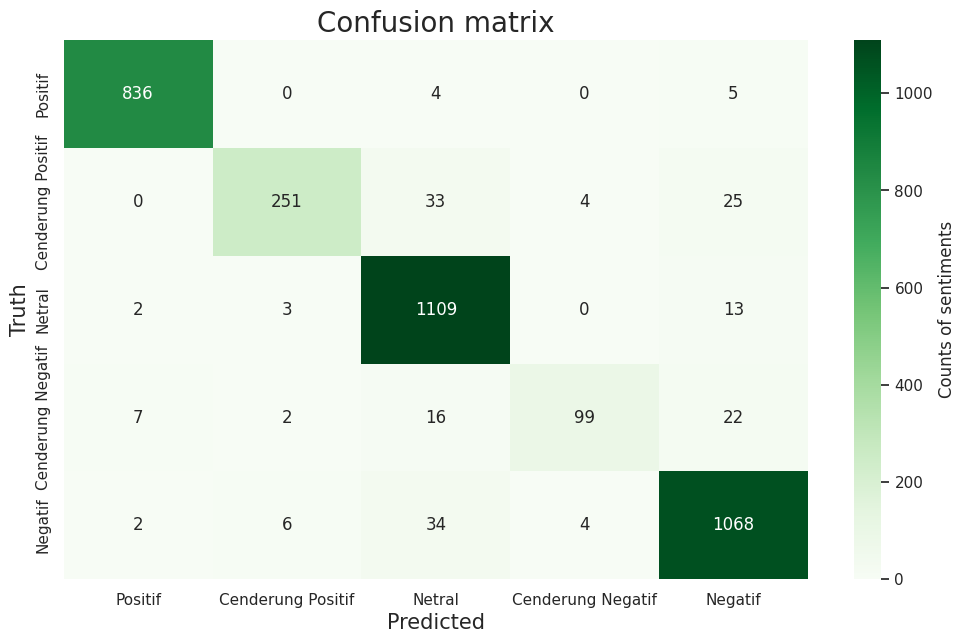

In [51]:
# Menghitung confusion matrixflat_true_labels, flat_prediction
cm_hasil = confusion_matrix(flat_true_labels, flat_prediction)

# Plot confusion matrix
plt.figure(figsize=(12, 7))
sentiment_classes = ['Positif', 'Cenderung Positif', 'Netral', 'Cenderung Negatif', 'Negatif']
sb.heatmap(cm_hasil, cmap=plt.cm.Greens, annot=True, cbar_kws={'label': 'Counts of sentiments'}, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.title('Confusion matrix', fontsize=20)
plt.show()

In [52]:
from sklearn.metrics import confusion_matrix

print(classification_report(flat_true_labels, flat_prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       845
           1       0.96      0.80      0.87       313
           2       0.93      0.98      0.95      1127
           3       0.93      0.68      0.78       146
           4       0.94      0.96      0.95      1114

    accuracy                           0.95      3545
   macro avg       0.95      0.88      0.91      3545
weighted avg       0.95      0.95      0.95      3545

